# The obscure facts behind the history of Philosophy (A guidebook to find the unknown interactions between schools and authors in the history of Philosophy)
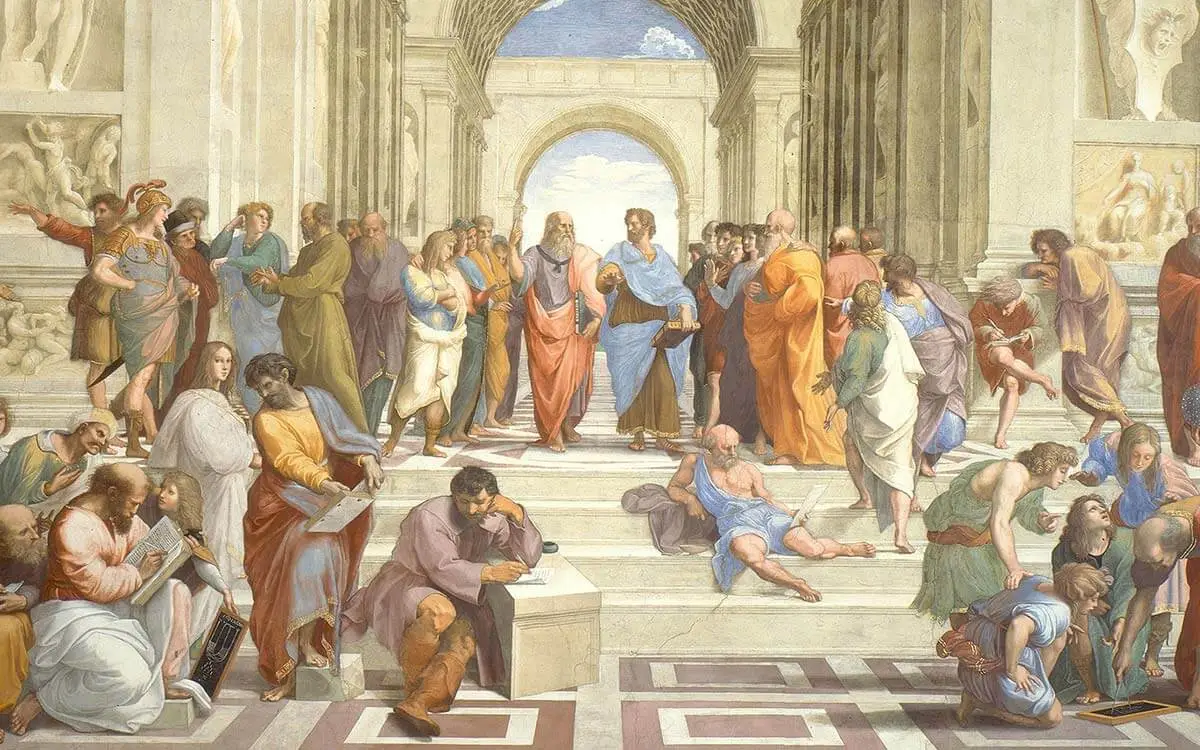

## Setup Google Drive Environment

In [147]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [148]:
#https://drive.google.com/file/d/1vs-qThVsfVDh91peCWus4x0knwNRcxy3/view?usp=sharing'
id = "1vs-qThVsfVDh91peCWus4x0knwNRcxy3"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('philosophy_data.csv')

## Load Data and Import packages

In [149]:
pip install NRCLex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
import numpy as np
import pandas as pd
import csv
import nltk
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import LatentDirichletAllocation
from nrclex import NRCLex
import plotly.express as px

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [151]:
# Load data into dataframe
df = pd.read_csv('philosophy_data.csv', quoting=csv.QUOTE_NONNUMERIC)
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350.0,1997.0,125.0,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350.0,1997.0,69.0,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350.0,1997.0,74.0,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350.0,1997.0,21.0,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350.0,1997.0,101.0,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


## Introduction and data preprocessing
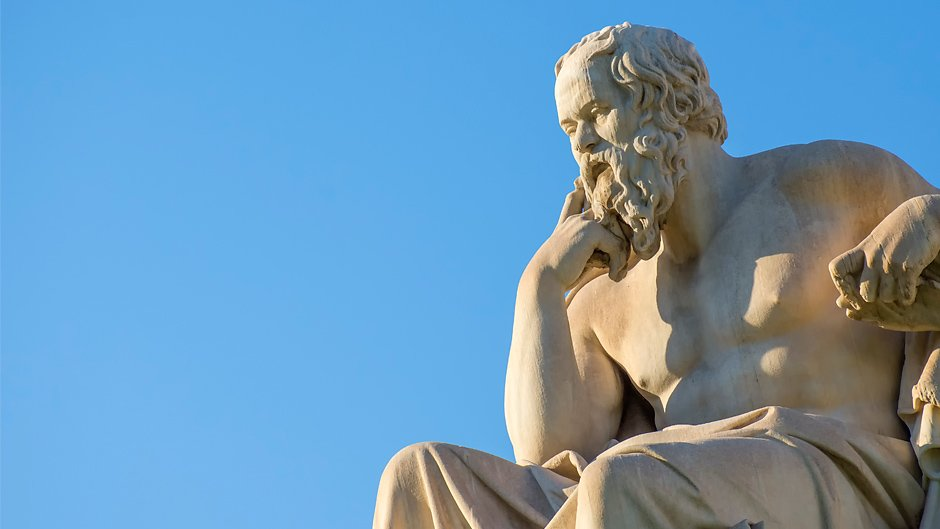

History has helped us record the ideological civilization and exploration steps left by mankind in the process of continuous development. Through history, people reflect and practice in different fields to promote the formation and development of society. In the field of philosophy, history records different doctrines advocated by various schools and regions such as Plato, Nietzsche, and Socrates, helping future generations to better learn and link to other fields.
However, in today's rapidly developed digital age, we are more eager to use numbers instead of long and complex words, to obtain maximum results in a short time. So, in this analysis, I gonna using power of data to show some unknown relationships between and within authors and schools.

We will use the data from Kaggle posted by Kourosh Alizaden called History of Philosophy, which was compiled for the Philosophy Data Project.

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   title                      360808 non-null  object 
 1   author                     360808 non-null  object 
 2   school                     360808 non-null  object 
 3   sentence_spacy             360808 non-null  object 
 4   sentence_str               360808 non-null  object 
 5   original_publication_date  360808 non-null  float64
 6   corpus_edition_date        360808 non-null  float64
 7   sentence_length            360808 non-null  float64
 8   sentence_lowered           360808 non-null  object 
 9   tokenized_txt              360808 non-null  object 
 10  lemmatized_str             360808 non-null  object 
dtypes: float64(3), object(8)
memory usage: 30.3+ MB


As we can see, this is a very well-rounded dataset with **360808** sentences, **10** features, and no missing values. Therefore, we do not need to drop any row to deal with missing values.

Now, let's count and graph the number of sentences recorded by each author and school to make sure we have a balanced dataset.

Text(0.5, 0.8, 'The distribution of authors')

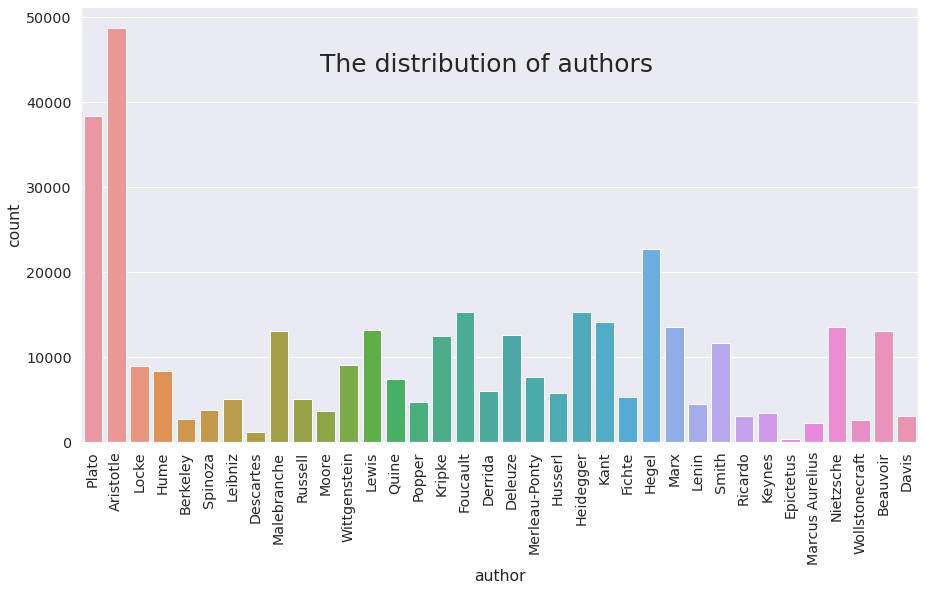

In [153]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 90)
ax = sns.countplot(x='author', data=df)
plt.suptitle("The distribution of authors", y = 0.8, fontsize=25)

Text(0.5, 1, 'The distribution of schools')

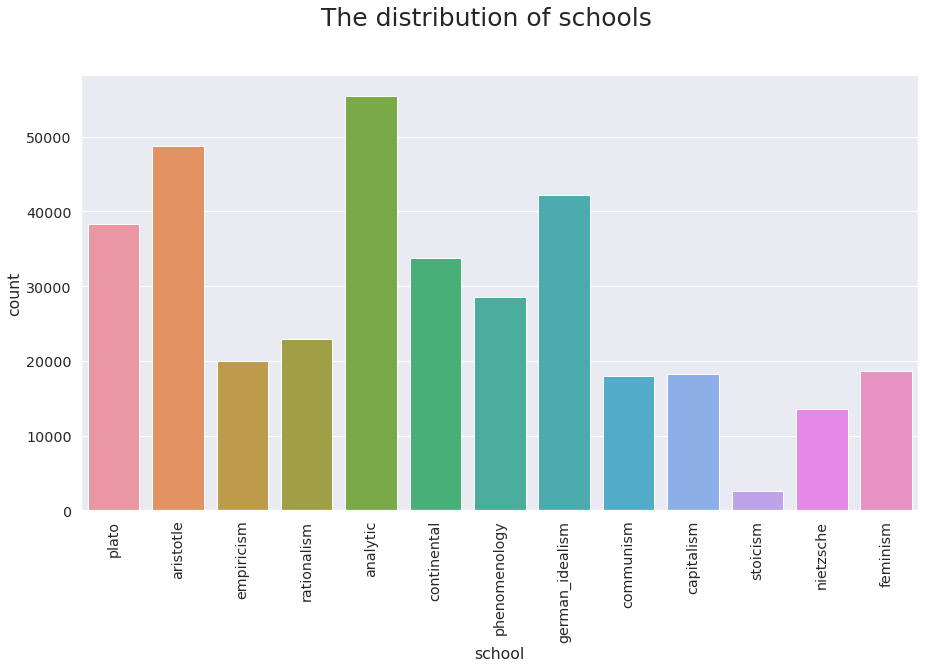

In [154]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 90)
sns.countplot(x='school', data=df)
plt.suptitle("The distribution of schools", y = 1, fontsize=25)

In [155]:
group_by_author = df.groupby(['author']).count()['tokenized_txt']
authors_higher_than_threshod = []
for i in group_by_author.index:
  print('Percentage of ' + i + ' ', group_by_author[i] / group_by_author.sum())
  if group_by_author[i] / group_by_author.sum() >= 0.01:
    authors_higher_than_threshod.append(i)

Percentage of Aristotle  0.13519378727744397
Percentage of Beauvoir  0.03607735970377597
Percentage of Berkeley  0.007577437307376776
Percentage of Davis  0.00847819338817321
Percentage of Deleuze  0.034755326932883975
Percentage of Derrida  0.016626571472916345
Percentage of Descartes  0.003137402718343274
Percentage of Epictetus  0.000895212966453072
Percentage of Fichte  0.01471142546728454
Percentage of Foucault  0.04223853129642358
Percentage of Hegel  0.06291434779716636
Percentage of Heidegger  0.0422357597392519
Percentage of Hume  0.023037183211015277
Percentage of Husserl  0.01591428127979424
Percentage of Kant  0.03915655972151393
Percentage of Keynes  0.009453781512605041
Percentage of Kripke  0.03458626194541141
Percentage of Leibniz  0.013932617902042083
Percentage of Lenin  0.012386089000243896
Percentage of Lewis  0.03636283009245915
Percentage of Locke  0.024625285470388683
Percentage of Malebranche  0.036021928560342344
Percentage of Marcus Aurelius  0.006130684463759

In [156]:
group_by_school = df.groupby(['school']).count()['tokenized_txt']
schools_higher_than_threshod = []
for i in group_by_school.index:
  print('Percentage of ' + i + ' ', group_by_school[i] / group_by_school.sum())
  if group_by_school[i] / group_by_school.sum() >= 0.01:
    schools_higher_than_threshod.append(i)

Percentage of analytic  0.15361355624043813
Percentage of aristotle  0.13519378727744397
Percentage of capitalism  0.05042571118157026
Percentage of communism  0.04977162368905346
Percentage of continental  0.0936204297022239
Percentage of empiricism  0.05523990598878074
Percentage of feminism  0.05164796789428172
Percentage of german_idealism  0.11678233298596484
Percentage of nietzsche  0.03754905656193876
Percentage of phenomenology  0.07919170306645086
Percentage of plato  0.10633356244872619
Percentage of rationalism  0.06360446553291502
Percentage of stoicism  0.00702589743021219


As we can see, we have an imbalance dataset, therefore sentences in which school or author with a percentage less than 0.01 will be dropped.

In [157]:
df = df[np.logical_or(df['author'].isin(authors_higher_than_threshod), df['school'].isin(schools_higher_than_threshod))]
df.shape

(358273, 11)

Now, I will compute the pairwise correlation of columns for feature selection.

In [158]:
df.corr()

,original_publication_date,corpus_edition_date,sentence_length
original_publication_date,1.000000,0.030833,0.066830
corpus_edition_date,0.030833,1.000000,0.017303
sentence_length,0.066830,0.017303,1.000000


After dropping those rows, there are **358273** sentences remaining. Now let's drop columns that I will not use in this analysis. I will not use the title because it is not the focus of this analysis. I will drop the sentence_spacy and sentence_str columns since we have their lowercase tokenized and lemmatized transformations already. The corpus_edition_date will be dropped because rationally it has almost no correlation to length (0.017303 from the table above).

In [159]:
to_drop = ['title','sentence_spacy','sentence_str', 'corpus_edition_date']
philosophy_df = df.drop(to_drop, axis=1)
philosophy_df.reset_index(inplace=True, drop=True)
philosophy_df.tail()

,author,school,original_publication_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
358268,Davis,feminism,1981.0,142.0,but the socialization of housework including m...,"['but', 'the', 'socialization', 'of', 'housewo...",but the socialization of housework include me...
358269,Davis,feminism,1981.0,117.0,the only significant steps toward endingdomest...,"['the', 'only', 'significant', 'steps', 'towar...",the only significant step toward endingdomest...
358270,Davis,feminism,1981.0,90.0,"working women, therefore, have a special and v...","['working', 'women', 'therefore', 'have', 'spe...","working woman , therefore , have a special an..."
358271,Davis,feminism,1981.0,199.0,"moreover, under capitalism, campaigns for jobs...","['moreover', 'under', 'capitalism', 'campaigns...","moreover , under capitalism , campaign for jo..."
358272,Davis,feminism,1981.0,126.0,this strategy calls into question the validity...,"['this', 'strategy', 'calls', 'into', 'questio...",this strategy call into question the validity...


Honestly, I am not good at Art education since I struggled during my upper-level writing course during my undergraduate study. And I have no idea or prior knowledge of Philosophy as well. But from the perspective of Data Science, I found this dataset pretty intriguing. After I skimmed through the dataset, some questions were raised naturally in my mind. Can we understand the history of Philosophy better by analyzing the words in their book? Therefore, I yielded three questions below, with increasing difficulty to perform the data analysis.

## First question: How are authors and schools different from others in terms of the length of sentences they produced?
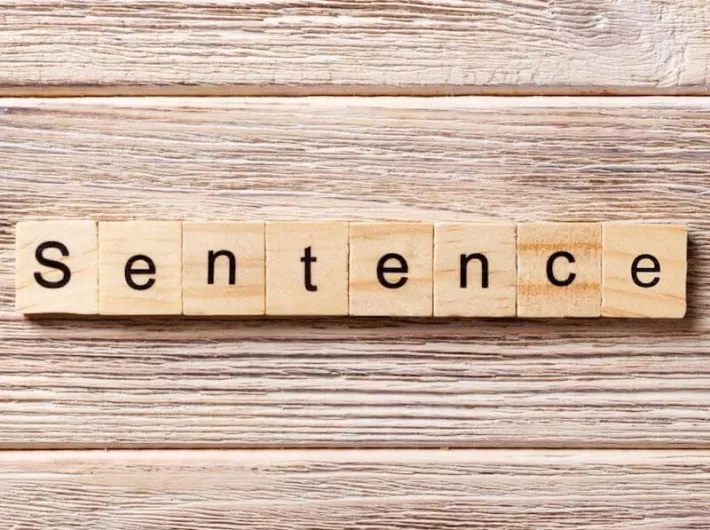

For the first question, I gonna use pandas and seaborn to analysis the relationship between author, school, original_publication_date, and sentence_length.



In [160]:
# columns containing the average original_publication_date  sentence_length for each author to the DataFrame.
author_df = philosophy_df.groupby(by = 'author').mean().reset_index()

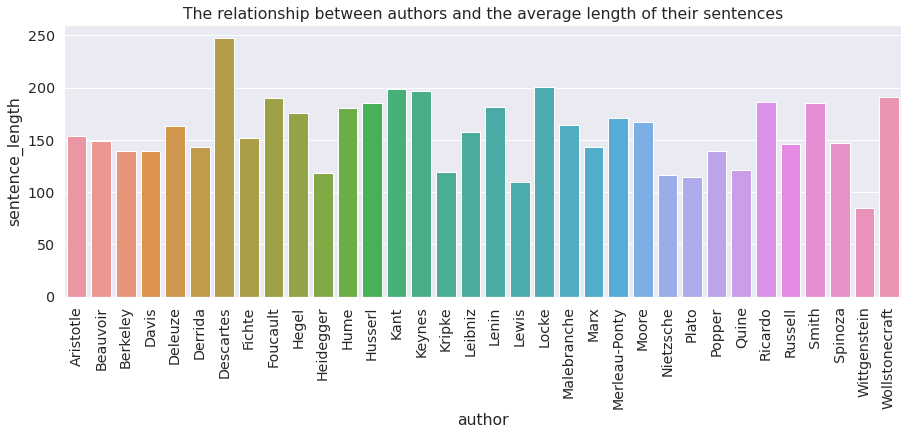

In [161]:
plt.figure(figsize=(15, 5))
sns.barplot(data=author_df,
            x="author",
            y="sentence_length"
           )

plt.title("The relationship between authors and the average length of their sentences")
plt.xticks(rotation = 90)
plt.show()

From the plot, we can see that Descartes is that unquestionable long-sentence writer with nearly 250 average sentence lengths and Wittgenstein prefers to use short sentences with an average sentence length of less than 100.

In [162]:
#Adding columns containing the average original_publication_date  sentence_length for each school to the DataFrame
school_df = philosophy_df.groupby(by = 'school').mean().reset_index()

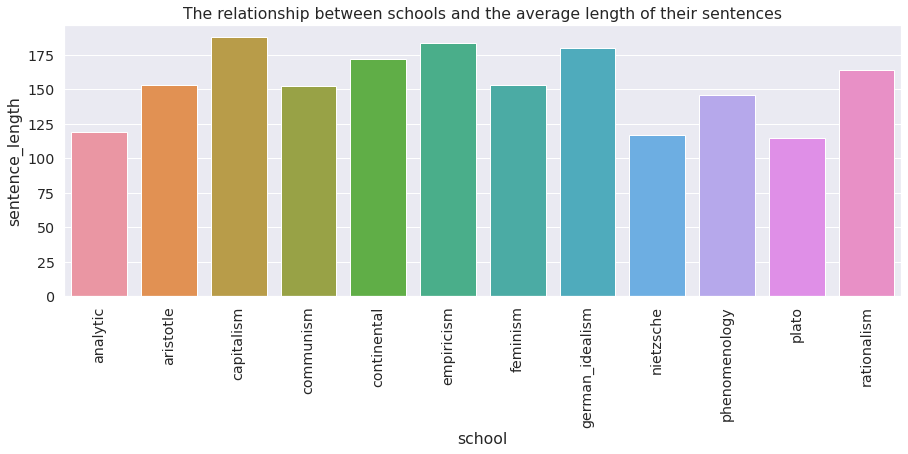

In [163]:
plt.figure(figsize=(15, 5))
sns.barplot(data=school_df,
            x="school",
            y="sentence_length"
           )

plt.title("The relationship between schools and the average length of their sentences")
plt.xticks(rotation = 90)
plt.show()

From the plot,  the average length of sentences in capitalism school is the longest compared with the average length of Plato school, the shortest school. This may be because that Plato is a school that only has Plato himself.

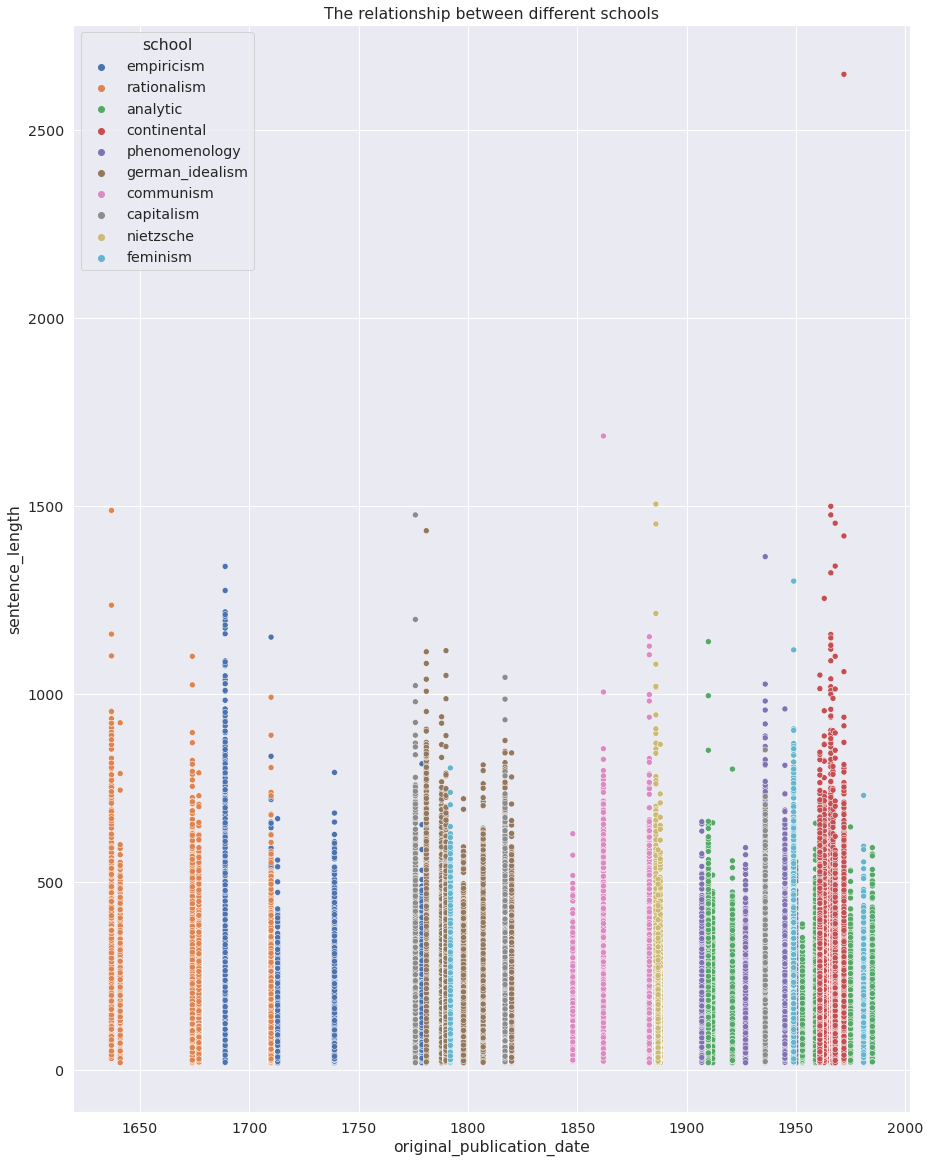

In [164]:
indexAuthor = philosophy_df[ (philosophy_df['author'] == 'Plato') | (philosophy_df['author'] == 'Aristotle') ].index
without_plato_aristotle = philosophy_df.drop(indexAuthor)
sns.set_theme(font_scale=1.3)

plt.figure(figsize=(15, 20))
sns.scatterplot(data=without_plato_aristotle,
                x="original_publication_date",
                y="sentence_length",
                hue="school"
               )

plt.title("The relationship between different schools")
plt.show()

Since Plato and Aristotle are so far away in terms of the publication date, I ignored them in the plot above. After Plato and Aristotle, we can see the diversification of schools. Various schools of thought rushed into the field of philosophy. 
According to the scatter plot, rationalism; empiricism; german_idealism; and analytic schools exist for a long time; communism lasts relatively long; while Nietzsche and continental are the two schools that disappeared. This fact indicates that the loyalties of supporters of these two schools are not high.

## Second question: Are authors from distinct schools speak in a similar tone or not? If not, what is the difference?

In the second section, I will perform the emotion analysis on the sentences.

In [165]:
philosophy_df.school.unique()

array(['plato', 'aristotle', 'empiricism', 'rationalism', 'analytic',
       'continental', 'phenomenology', 'german_idealism', 'communism',
       'capitalism', 'nietzsche', 'feminism'], dtype=object)

Since school plato and aristotle only contain themselves, I will not analyze those two schools. Obviously, They always speak in a similar tone. To avoid long and redundant work, I will only choose three schools that I am most interested in to analyze.

In [166]:
#get DataFrames containing all authors from same schools
empiricism_df = philosophy_df.loc[(philosophy_df['school'] == 'empiricism'), :].iloc[:1000,:].reset_index()
capitalism_df = philosophy_df.loc[(philosophy_df['school'] == 'capitalism'), :].iloc[:1000,:].reset_index()
feminism_df = philosophy_df.loc[(philosophy_df['school'] == 'feminism'), :].iloc[:1000,:].reset_index()

In [167]:
#https://www.geeksforgeeks.org/python-combine-two-dictionary-adding-values-for-common-keys/
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
#Function used to get total emotion score of sentences from a school
def get_emotion_scores(df):
  emotion_dict = {'anticipation': 0,'fear' : 0, 'anger': 0, 'trust': 0, 'surprise': 0, 'positive': 0, 'negative': 0, 'sadness': 0, 'disgust': 0, 'joy': 0}
  for i in range(df.shape[0]):
    emotion = NRCLex(df.loc[i, 'sentence_lowered'])    
    scores = emotion.raw_emotion_scores
    for key in scores:
        emotion_dict[key] = emotion_dict[key] + scores[key]
  return emotion_dict

In [168]:
empiricism_score = get_emotion_scores(empiricism_df)

In [169]:
#https://medium.com/geekculture/simple-emotion-classification-in-python-40fb24692541
empiricism_emotion_df = pd.DataFrame.from_dict(empiricism_score, orient='index').reset_index()
empiricism_emotion_df = empiricism_emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
empiricism_emotion_df = empiricism_emotion_df.sort_values(by=['Emotion Count'], ascending=False)
fig = px.bar(empiricism_emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

The first school I picked is empiricism. From the plot, we can see that most of the emotion words in this school are positive and about trust. This is easy to understand because empiricism means trusting the experiences in the past in order to make the future decision.

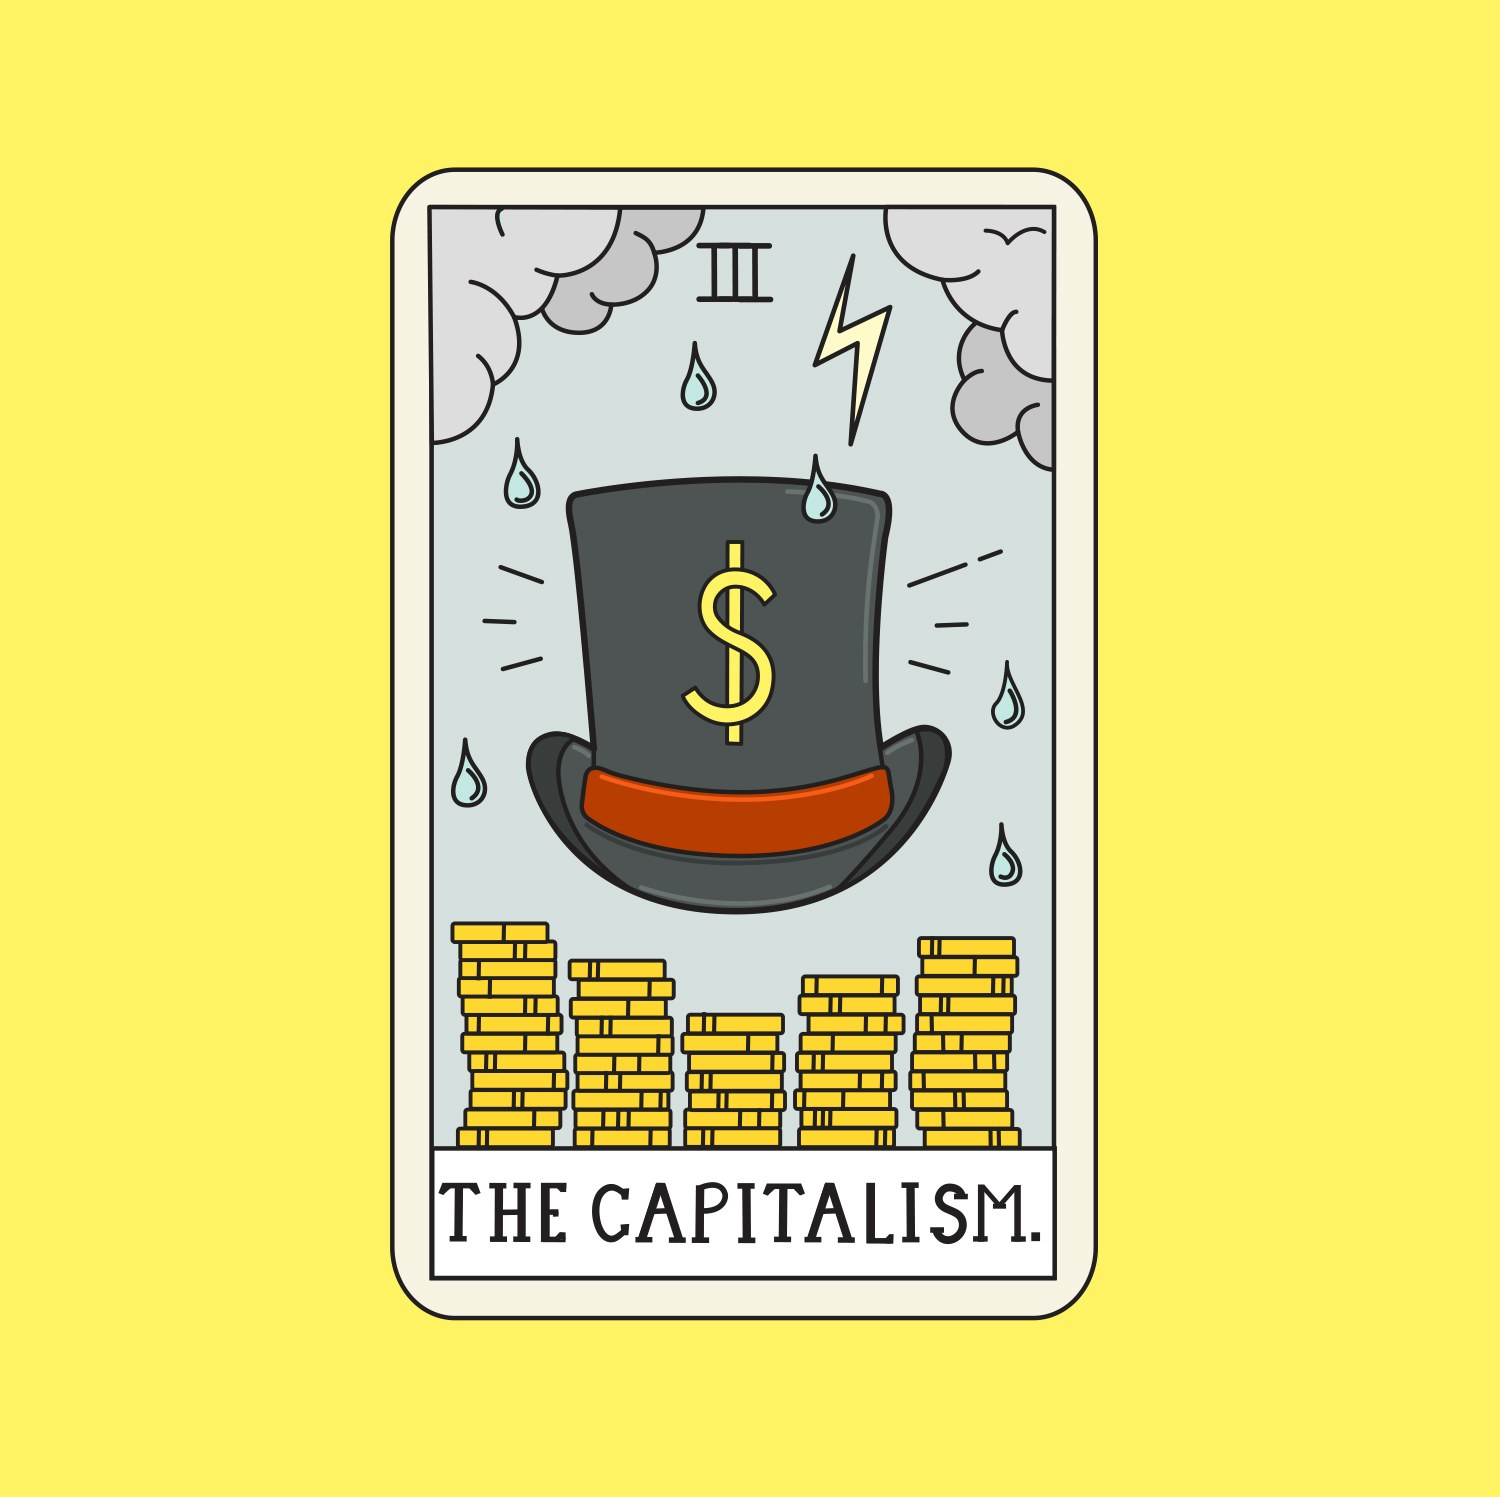

In [170]:
capitalism_score = get_emotion_scores(capitalism_df)

In [171]:
capitalism_df = pd.DataFrame.from_dict(capitalism_score, orient='index').reset_index()
capitalism_df = capitalism_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
capitalism_df = capitalism_df.sort_values(by=['Emotion Count'], ascending=False)
fig = px.bar(capitalism_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

  For capitalism, positive emotion dominates again. Compared to empiricism, the percentage of fear highly decreases, which implies authors from capitalism have less fear and are very confident.

In [172]:
feminism_score = get_emotion_scores(feminism_df)

In [173]:
feminism_emotion_df = pd.DataFrame.from_dict(feminism_score, orient='index').reset_index()
feminism_emotion_df = feminism_emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
feminism_emotion_df = feminism_emotion_df.sort_values(by=['Emotion Count'], ascending=False)
fig = px.bar(feminism_emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

As most of the words are positive for feminism. We can see a high percentage of joy compared to other schools. This implies authors in feminism prefer to use 'happy' words for their own sake.

## Last question: Can we guess the school name backhead by only exposing the sentences themselves?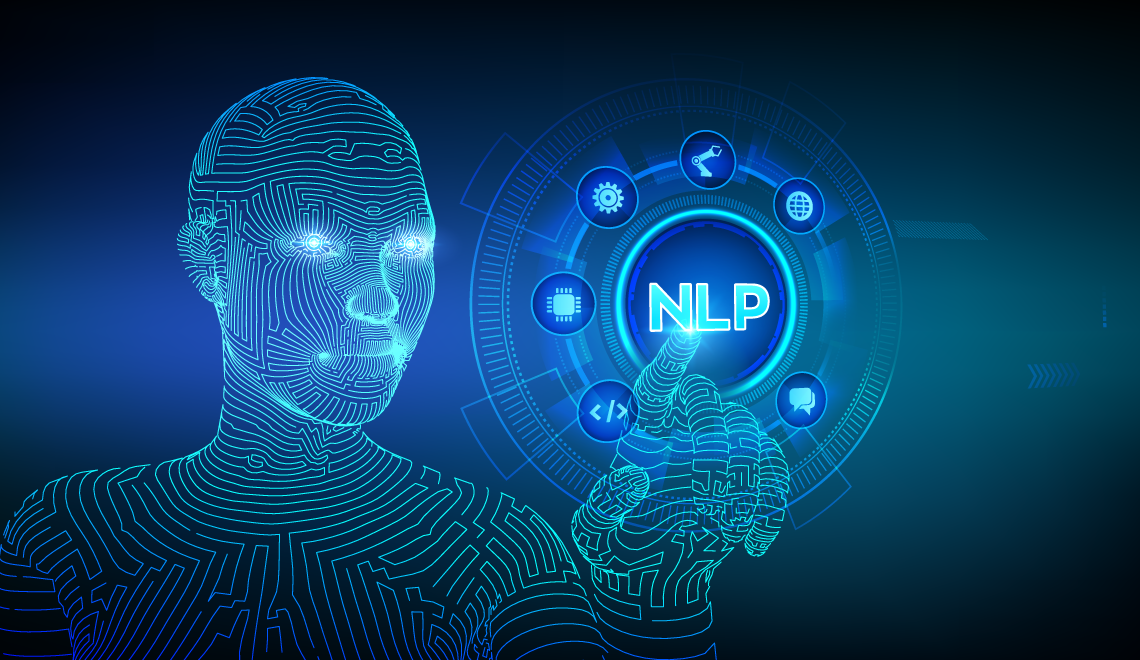

For the last part of analysis, I am going to use NLP to make prediction of the author and school based solely on the sentence! Let's see if we can get them right!

I will randomly choose 60000 sentences as training set since original dataset is too huge for Colab to handle. 5000 sentences each school to keep the dataset balance.

In [174]:
randomized_data = pd.DataFrame()

In [175]:
randomized_data = philosophy_df.sample(philosophy_df.shape[0])

In [176]:
#https://stackoverflow.com/questions/41825978/sorting-columns-and-selecting-top-n-rows-in-each-group-pandas-dataframe
group = randomized_data.groupby('school')
data = pd.DataFrame([], columns = randomized_data.columns)
for key, values in group:
    data = pd.concat([data, group.get_group(key)[:5000]])

In [177]:
data = data.loc[:, 'sentence_lowered'].tolist()

Use nltk's English stopwords to remove unmeaningful words. Using stemming for removing the suffix from the words and reduce them to their root words.

In [178]:
#https://pythonspot.com/nltk-stop-words/#:~:text=By%20default%2C%20NLTK%20(Natural%20Language,defined%20and%20cannot%20be%20removed.
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#https://www.geeksforgeeks.org/snowball-stemmer-nlp/
#https://www.geeksforgeeks.org/python-nltk-nltk-tokenizer-word_tokenize/

stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")
# function for tokenization and stemming
def remove_stopwords_plus_stemming(text):
    tokens = []
    # exclude stopwords
    for word in nltk.word_tokenize(text):
        if word not in stopwords:
            tokens.append(word)
    new_tokens = []
    for token in tokens:
        if token.isalpha():
            new_tokens.append(token)
    stems = [stemmer.stem(t) for t in new_tokens]
    return stems

In order to do the LDA topic modeling, we need to calculate the TF-IDF matrix first. It is a matrix representing how important a word is to a document in a collection. 
(Reference: https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [179]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tf_model = TfidfVectorizer(max_df=0.999, max_features=1000,
                                 min_df=0.001, stop_words='english',
                                 tokenizer=remove_stopwords_plus_stemming)
tf_matrix = tf_model.fit_transform(data)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



In [180]:
tf_matrix.shape

(60000, 1000)

Now, it is time for LDA.

In [181]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
lda = LatentDirichletAllocation(n_components=12)
lda_result = lda.fit_transform(tf_matrix)

First of all, we can show the level of relevance for each sentence on all the schools.

In [182]:
df_sentence_school = pd.DataFrame(np.round(lda_result, 2), columns=["school" + str(i) for i in range(lda.n_components)], index=["sentence" + str(i) for i in range(len(data))])
# display dominant school for each sentence
df_sentence_school['dominant_school'] = np.argmax(df_sentence_school.values, axis=1)
df_sentence_school.head()

,school0,school1,school2,school3,school4,school5,school6,school7,school8,school9,school10,school11,dominant_school
sentence0,0.54,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0
sentence1,0.03,0.03,0.03,0.03,0.62,0.03,0.03,0.03,0.03,0.03,0.03,0.03,4
sentence2,0.02,0.02,0.02,0.02,0.02,0.02,0.75,0.02,0.02,0.02,0.02,0.02,6
sentence3,0.02,0.02,0.02,0.02,0.80,0.02,0.02,0.02,0.02,0.02,0.02,0.02,4
sentence4,0.03,0.03,0.03,0.03,0.03,0.03,0.62,0.03,0.03,0.03,0.03,0.03,6


In [183]:
# display the total number of sentences LDA predicted to belong to each group
df_sentence_school['dominant_school'].value_counts()

3     7078
4     6675
6     5820
10    5255
0     5186
1     5005
5     4980
8     4583
7     4200
2     4128
11    3993
9     3097
Name: dominant_school, dtype: int64

As we chose 5000 sentences from each school as our training data, the above numbers make sense as they do not deviate from 5000 a lot.

Now we can create a table showing the importance of each word in schools.

In [184]:
df_school_word = pd.DataFrame(lda.components_)
df_school_word.columns = tf_model.get_feature_names_out()
df_school_word.index = ["school" + str(i) for i in range(lda.n_components)]
df_school_word.head()

,abl,absolut,abstract,absurd,accept,accompani,accomplish,accord,account,accumul,...,worker,world,worth,write,wrong,ye,year,yield,young,zarathustra
school0,8.353027,8.965440,0.677882,0.561599,14.142582,0.083335,10.144460,21.570773,58.720126,0.083334,...,0.083334,47.518759,0.083334,0.145594,0.083335,0.083333,0.083334,0.083335,0.083334,0.083334
school1,27.351223,10.187775,3.792149,28.982982,12.105622,31.803573,1.653515,23.752038,20.879781,0.083334,...,0.083333,21.535676,39.266420,0.083334,0.083335,0.083334,0.083334,0.101912,0.083334,0.083337
school2,16.134336,3.340247,0.083334,7.690167,6.937629,0.083334,0.083334,17.205897,5.570628,0.083340,...,54.086078,22.416682,2.981978,84.001933,6.799538,0.083334,117.156799,2.577496,12.161794,0.083334
school3,13.542053,12.632422,1.144964,4.706298,2.380876,10.164492,0.083336,39.251396,34.325792,53.782007,...,22.483767,12.840477,17.934338,0.083350,0.083333,0.083333,101.435053,17.916006,0.083334,0.083333
school4,15.548848,83.982323,88.951874,7.909067,0.083336,0.083334,14.146420,75.528010,12.718213,0.083334,...,0.083334,70.547818,0.083335,0.450846,0.083335,0.083333,0.083334,4.146776,0.083333,0.083333


Let's show the top 10 keywords for each school

In [185]:
#https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
# print top n keywords for each school
def print_school_words(tf_model, lda_model, n):
    words = np.array(tf_model.get_feature_names())
    school_words = []
    for school_words_weights in lda_model.components_:
        top_words = school_words_weights.argsort()[::-1][:n]
        school_words.append(words.take(top_words))
    return school_words

school_keywords = print_school_words(tf_model, lda, 10)
df_school_words = pd.DataFrame(school_keywords)
df_school_words.columns = ['Word '+str(i) for i in range(df_school_words.shape[1])]
df_school_words.index = ['School '+str(i) for i in range(df_school_words.shape[0])]
df_school_words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
School 0,socrat,dasein,way,self,christian,correct,freedom,error,non,ontolog
School 1,good,love,reason,pleasur,pain,evil,thing,certain,knowledg,fear
School 2,women,men,argument,philosophi,year,book,new,mani,die,father
School 3,labour,valu,capit,price,money,product,countri,employ,increas,commod
School 4,object,determin,concept,scienc,sens,understand,pure,subject,form,univers
School 5,law,god,state,natur,power,govern,person,equal,etern,order
School 6,bodi,idea,motion,mind,caus,earth,soul,chang,time,water
School 7,say,know,let,someth,like,els,tell,thing,anyth,noth
School 8,woman,man,eye,littl,young,white,look,night,read,like
School 9,question,answer,ask,want,idea,anim,machin,social,hard,simpl


Yes! We can guess the school name backhead! And it is finally our time to guess the school! I am not the expertise of philosophy. So I am highly likely to be wrong!

In [186]:
My_school_guess = ["rationalism","empiricism","german_idealism","nietzsche","feminism", "aristotle" , "analytic", "communism",
          "continental", "plato", "capitalism", "phenomenology"]
df_school_words["School"] = My_school_guess
df_school_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,School
School 0,socrat,dasein,way,self,christian,correct,freedom,error,non,ontolog,rationalism
School 1,good,love,reason,pleasur,pain,evil,thing,certain,knowledg,fear,empiricism
School 2,women,men,argument,philosophi,year,book,new,mani,die,father,german_idealism
School 3,labour,valu,capit,price,money,product,countri,employ,increas,commod,nietzsche
School 4,object,determin,concept,scienc,sens,understand,pure,subject,form,univers,feminism
School 5,law,god,state,natur,power,govern,person,equal,etern,order,aristotle
School 6,bodi,idea,motion,mind,caus,earth,soul,chang,time,water,analytic
School 7,say,know,let,someth,like,els,tell,thing,anyth,noth,communism
School 8,woman,man,eye,littl,young,white,look,night,read,like,continental
School 9,question,answer,ask,want,idea,anim,machin,social,hard,simpl,plato


### That is my guess! What is your guess?
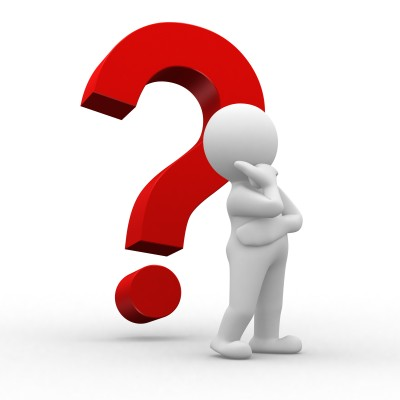

## Conclusion

From this notebook, I have a deeper understanding of the history of Philosophy by using the power of data analysis and found many things that I will not know without the help of data science. I analyzed the relationship between authors, schools, and the average length of sentences. I found the author and school with the lowest and highest average word count in their sentences. I also had an idea about the ups and downs of each school in the history of Philosophy and the relationship between them. Then I did an emotion/sentiment analysis on three schools. For example, I found sentences from empiricism tend to have more trust related emotional words than other schools. I used the LDA model to provide me with top keywords for each unknown, allowing me to guess the school with exposure to sentence only.

## Image Reference

1. https://authortomharper.com/2022/04/28/philosophy-everything-you-need-to-know/
2. https://lmhsrampage.com/2020/02/05/capitalism-is-ruining-our-mental-health/#
3. https://www.quickanddirtytips.com/articles/sentence-length/
4. https://flc.losrios.edu/academics/programs-and-majors/philosophy
5. https://www.xoriant.com/blog/natural-language-processing-the-next-disruptive-technology-under-ai-part-i
6. https://proofthatblog.com/2013/07/01/the-question-is-what-happened-to-the-question-mark/